In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(ggpubr)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(factoextra)
library(ggrepel)
library(dplyr)
library(plyr)
library(cowplot)
library(lme4)
library(mice)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘ggpubr’

The following object is masked from ‘package:VennDiagram’:

    rotate

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to den

In [2]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC <- "#FFCC00"

In [3]:
title_size <- 12

In [4]:
setwd("~/ownCloud/Meng/")

In [5]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

colnames(metadata)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [6]:
colSums(is.na(metadata))

nbb                             autopsy 
                                  0                                   0 
sampleprepRandomization (4 batches)        zmRandomization (10 batches) 
                                  0                                   0 
                         Autopsy_nr                               GROUP 
                                  0                                   0 
            Mass-Spec filenames (1)             Mass-Spec filenames (2) 
                                  0                                 208 
                          Diagnosis                                 sex 
                                  0                                   0 
                                age                               braak 
                                  0                                   2 
                            amyloid                                 pmd 
                                 28                                   2 
                                 ph                              weight 
                                 13                                   2 
                                csf                                apoe 
                                  8                                  18 
                            barcode                               Abeta 
                                 66                                  19 
                               APOE 
                                 16

In [7]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)


names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

#print(filenames_map_index)

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

colSums(is.na(metadata))

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="AD") & (!is.na(metadata$amyloid))),]$amyloid)
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="ND") & (!is.na(metadata$amyloid))),]$amyloid)

metadata$O_amyloid <- sapply(metadata$amyloid, function(x){
    if(is.na(x)){
        return(NA)
    }
    if(round(x) == 0){
        return("O")
    }
    if(round(x) == 1){
        return("A")
    }
    if(round(x) == 2){
        return("B")
    }
    if(round(x) == 3){
        return("C")
    }
    
})

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which((metadata$apoe == 22)|(metadata$apoe == 23)|(metadata$apoe == 32)),]$apoe_OR <- 0.6
metadata[which((metadata$apoe == 24)|(metadata$apoe == 42)),]$apoe_OR <- 2.6
metadata[which(metadata$apoe == 33),]$apoe_OR <- 1
metadata[which((metadata$apoe == 34)|(metadata$apoe == 43)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe == 44),]$apoe_OR <- 14.9

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)


[1] 3448  191

nbb   autopsy       sex       age    weight     GROUP       pmd     braak 
        0         0         0         0         2         0         2         2 
  amyloid      apoe filenames 
       17        16         0

In [8]:
summary(metadata)

     nbb              autopsy              sex                 age       
 Length:190         Length:190         Length:190         Min.   : 50.0  
 Class :character   Class :character   Class :character   1st Qu.: 78.0  
 Mode  :character   Mode  :character   Mode  :character   Median : 89.0  
                                                          Mean   : 86.8  
                                                          3rd Qu.:100.0  
                                                          Max.   :111.0  
    weight             GROUP               pmd                braak      
 Length:190         Length:190         Length:190         Min.   :0.000  
 Class :character   Class :character   Class :character   1st Qu.:2.000  
 Mode  :character   Mode  :character   Mode  :character   Median :4.000  
                                                          Mean   :3.611  
                                                          3rd Qu.:5.000  
                                      

In [9]:
table(metadata$amyloid, metadata$GROUP)

   
    AD CHC ND
  0  0   3 13
  1  0  18 23
  2  7  14 15
  3 81  14  2

In [10]:
table(metadata$braak, metadata$GROUP)

   
    AD CHC ND
  0  0   0  6
  1  0   1 22
  2  0   6 17
  3  0  24  8
  4 20  14  0
  5 43   4  0
  6 25   0  0

In [11]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [12]:
metadata

,nbb,autopsy,sex,age,weight,GROUP,pmd,braak,amyloid,apoe,filenames,fBraak,cBraak,O_amyloid,apoe_OR,pmd_numeric
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
121,2016-020,S16/020,F,102,955,CHC,06:10,2,1,23,20190325_121_S16_020_CHC_011,2,1,A,0.6,6.166667
125,2016-044,S16/044,F,102,1015,CHC,05:17,3,3,33,20190325_125_S16_044_CHC_007,3,2,C,1.0,5.283333
127,2016-094,S16/094,F,104,1045,CHC,07:55,3,1,33,20190325_127_S16_094_CHC_004,3,2,A,1.0,7.916667
16,2004-011,04/037,F,84,1017,AD,05:55,5,3,33,20190325_16_04_037_AD_008,5,3,C,1.0,5.916667
182,2010-101,S10/292,M,64,1233,AD,04:35,6,3,32,20190325_183_S10_292_AD_010,6,3,C,0.6,4.583333
193,2002-024,S02/055,F,75,1153,ND,05:30,1,3,42,20190325_194_S02_055_ND_005,1,1,C,2.6,5.500000
31,2001-081,01/184,F,93,1010,AD,05:05,5,3,33,20190325_31_01_184_AD_006,5,3,C,1.0,5.083333
57,1997-091,S97/235,F,85,1000,AD,02:00,5,3,43,20190325_57_S97_235_AD_003,5,3,C,3.2,2.000000
77,2011-072,S11/072,F,76,1072,ND,07:15,2,0,33,20190325_77_S11_072_ND_012,2,1,O,1.0,7.250000


In [13]:
path <- "iQTL_result/data/peptide_quality-after_sample_filtering.tsv"
raw_data <- read.table(path, header = T, stringsAsFactors = F, sep = "\t")
peptide_quality <- raw_data[, grep("qvalue_", colnames(raw_data))]

path <- "iQTL_result/data/peptide_intensity-after_sample_filtering.tsv"
raw_data <- read.table(path, header = T, stringsAsFactors = F, sep = "\t")
peptide_info <- raw_data[, c(1, 2)]
peptide_intensity <- raw_data[, grep("intensity_", colnames(raw_data))]

In [14]:
log2_peptide_intensity <- log2(peptide_intensity)
dim(peptide_intensity)

[1] 28191   190

In [118]:
protein_name <- "RPS27A;UBA52;UBB;UBC"

In [119]:
peptide_info[which(peptide_info$protein == protein_name), ]

,peptide_id,protein
,<chr>,<chr>
6349,_ESTLHLVLR_.2,RPS27A;UBA52;UBB;UBC
11733,_IQDKEGIPPDQQR_.3,RPS27A;UBA52;UBB;UBC
23048,_TITLEVEPSDTIENVKAK_.3,RPS27A;UBA52;UBB;UBC
23049,_TITLEVEPSDTIENVK_.3,RPS27A;UBA52;UBB;UBC
23267,_TLSDYNIQK_.2,RPS27A;UBA52;UBB;UBC


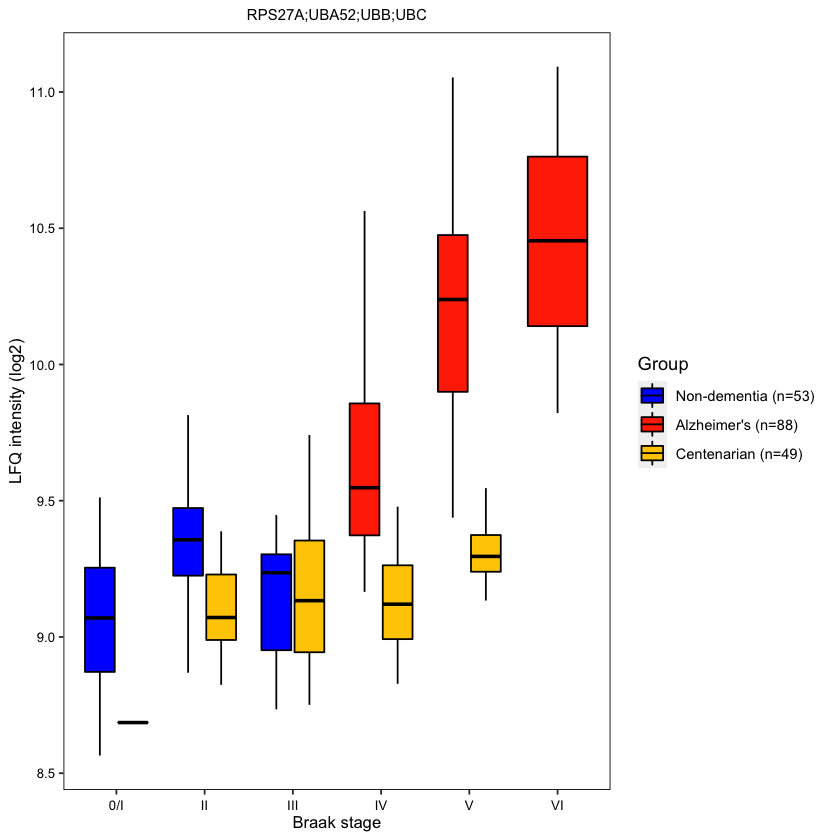

In [120]:
temp_prot <- data.frame(Braak = as.factor(round(metadata$fBraak)),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(protein_intensity_combat[rownames(protein_intensity_combat) == protein_name,]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))

xlabels <- sort(unique(temp_prot$Braak))
APP_plot <- ggplot(subset(temp_prot, group != "NONE"), aes(x = Braak, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("Braak stage") +
    ylab("LFQ intensity (log2)") +
    ggtitle(protein_name) +
    scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +

    scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                      values = c(color_ND, color_AD, color_CHC), 
                      labels = c("Non-dementia (n=53)", 
                                 "Alzheimer's (n=88)",
                                 "Centenarian (n=49)"))+
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          panel.border = element_rect(color = "black", size = 0.5, fill=NA),       # Border around plotting area.
                                               # fill argument should be NA
            
          legend.position='right',
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(), #element_line(size = 0.5, linetype = 'dashed',
                                #color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(), #element_line(size = 0.5, linetype = 'dashed',
                                #color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5, size = 9),
          axis.title.x = element_text(color = "black", size = 10),
          axis.title.y = element_text(color = "black", size = 10),
          
          axis.text.x = element_text(size = 8, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black"),
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                        colour = "black")
         )
    
APP_plot


In [115]:
save_plot("100_plus_plots/proteomics/MAPT_vs_Braak_stage_20220923.pdf", 
          APP_plot, base_height = 3, base_width = 3)

In [121]:
get_peptide_sequence <- function(peptide){
    clean_peptide <- unlist(strsplit(peptide, split = "\\_"))[2]
    clean_peptide <- str_remove_all(clean_peptide, "\\[.+?\\]")
    return(clean_peptide)
}

In [122]:
target_peptide_plot <- list()
j <- 1

for(i in which(peptide_info$protein == protein_name)){
    print(i)
    plot_data <- data.frame(intens = as.numeric(log2_peptide_intensity[i, ]),
                            Braak = as.factor(metadata$fBraak),
                            Abeta = as.factor(round(metadata$amyloid)),
                            group = metadata$GROUP)
    
    plot_data$group <- factor(plot_data$group, levels=c("ND", "AD", "CHC"))
    xlabels <- sort(unique(plot_data$Braak))
    
    p <- ggplot(subset(plot_data, group != "NONE"), aes(x = Braak, y = intens, fill = group))+
            geom_boxplot(color = "black") +
            xlab("Braak stage") +
            ylab("LFQ intensity (log2)") +
            ggtitle(get_peptide_sequence(peptide_info[i, ]$peptide_id)) +
            scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +
        
            scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                               values = c(color_ND, color_AD, color_CHC))+
        
            theme_bw() + theme(legend.position = "none",
                               plot.title = element_text(size = title_size))
    target_peptide_plot[[j]] <- p
    j  <- j + 1
}

[1] 6349
[1] 11733
[1] 23048
[1] 23049
[1] 23267


In [123]:
p <- plot_grid(plotlist = target_peptide_plot, ncol = 3, label_size = 12, hjust = 0,
               labels = letters[1:length(target_peptide_plot)])

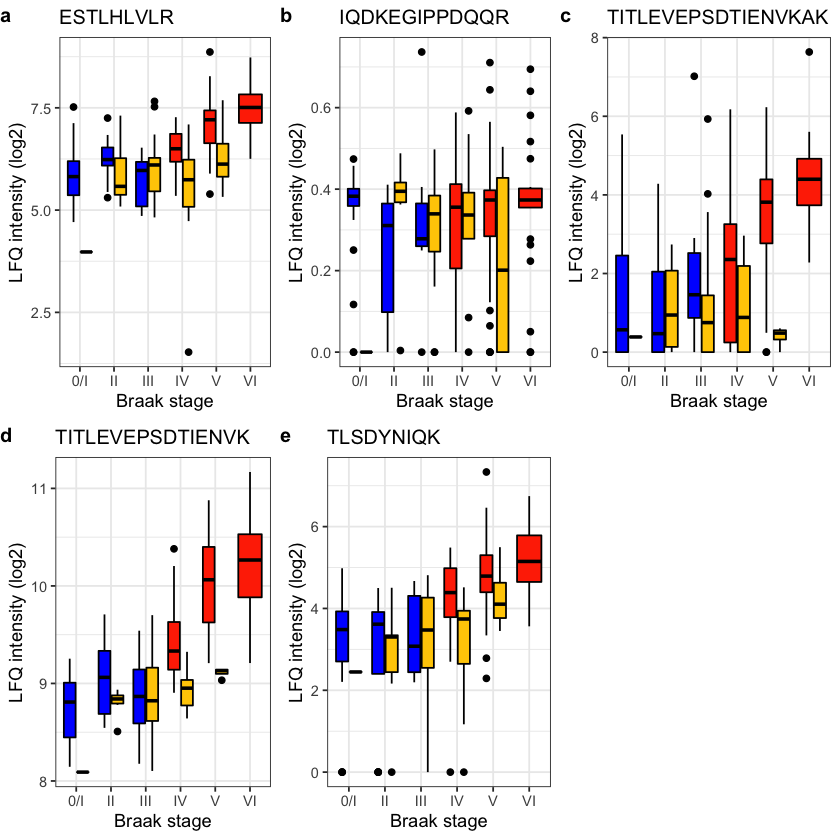

In [124]:
p

In [108]:
save_plot("100_plus_plots/proteomics/MAPT_and_peptide_correlation_with_Braak_20220921.pdf", 
          p, base_height = 20, base_width = 10)

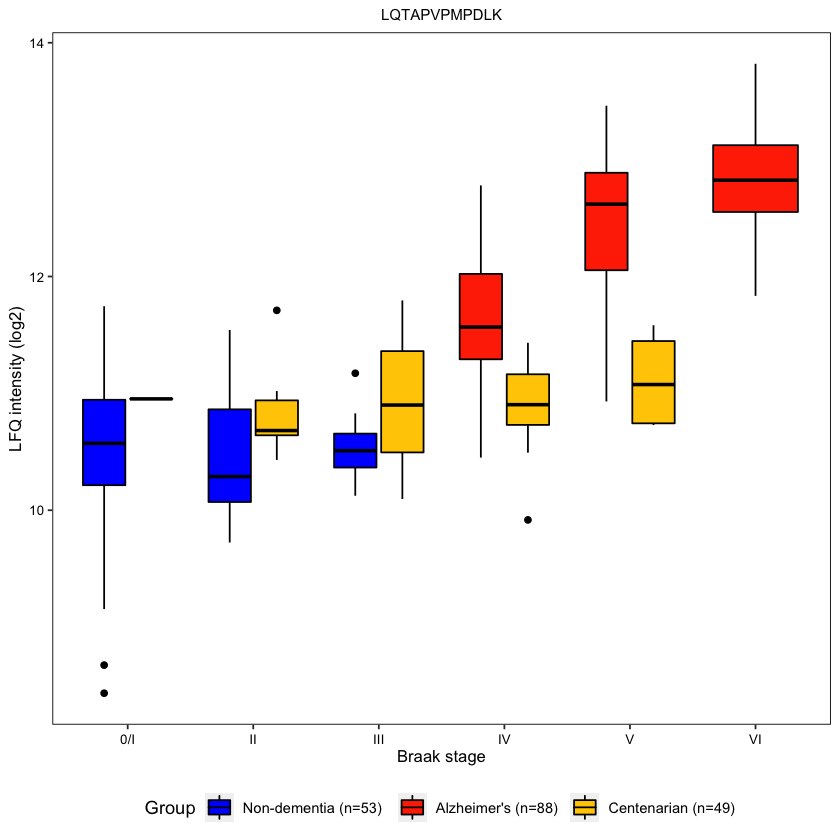

In [112]:
temp_prot <- data.frame(Braak = as.factor(round(metadata$fBraak)),
                        group = as.character(metadata$GROUP),
                        intensity = as.numeric(log2_peptide_intensity[15685, ]))
temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))

xlabels <- sort(unique(temp_prot$Braak))
Braak_plot <- ggplot(subset(temp_prot, group != "NONE"), aes(x = Braak, y = intensity, fill = group))+
    geom_boxplot(color = "black") +
    xlab("Braak stage") +
    ylab("LFQ intensity (log2)") +
    ggtitle(get_peptide_sequence(peptide_info[15685, ]$peptide_id)) +
    scale_x_discrete(breaks=xlabels, labels = c("0/I", "II", "III", "IV", "V", "VI")) +

    scale_fill_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                      values = c(color_ND, color_AD, color_CHC), 
                      labels = c("Non-dementia (n=53)", 
                                 "Alzheimer's (n=88)",
                                 "Centenarian (n=49)"))+
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          panel.border = element_rect(color = "black", size = 0.5, fill=NA),       # Border around plotting area.
                                               # fill argument should be NA
            
          legend.position='bottom',
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(), #element_line(size = 0.5, linetype = 'dashed',
                                #color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(), #element_line(size = 0.5, linetype = 'dashed',
                                #color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5, size = 9),
          axis.title.x = element_text(color = "black", size = 10),
          axis.title.y = element_text(color = "black", size = 10),
          
          axis.text.x = element_text(size = 8, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black"),
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                        colour = "black")
         )
    
Braak_plot


In [113]:
save_plot("100_plus_plots/proteomics/MAPT_peptide_pattern2_vs_Braak_stage_20220923.pdf", 
          Braak_plot, base_height = 3, base_width = 3)

In [70]:
legend <- get_legend(APP_plot)
APP_plot <- APP_plot + theme(legend.position='none')

In [71]:
APP_peptide_plot <- plot_grid(APP_plot, target_peptide_plot[[3]], target_peptide_plot[[4]],
                      align = "hv", axis = "lrtb", labels = c("c", "d", "e"), 
                      label_size = 12, hjust = 0,
                      nrow = 1, ncol = 3)

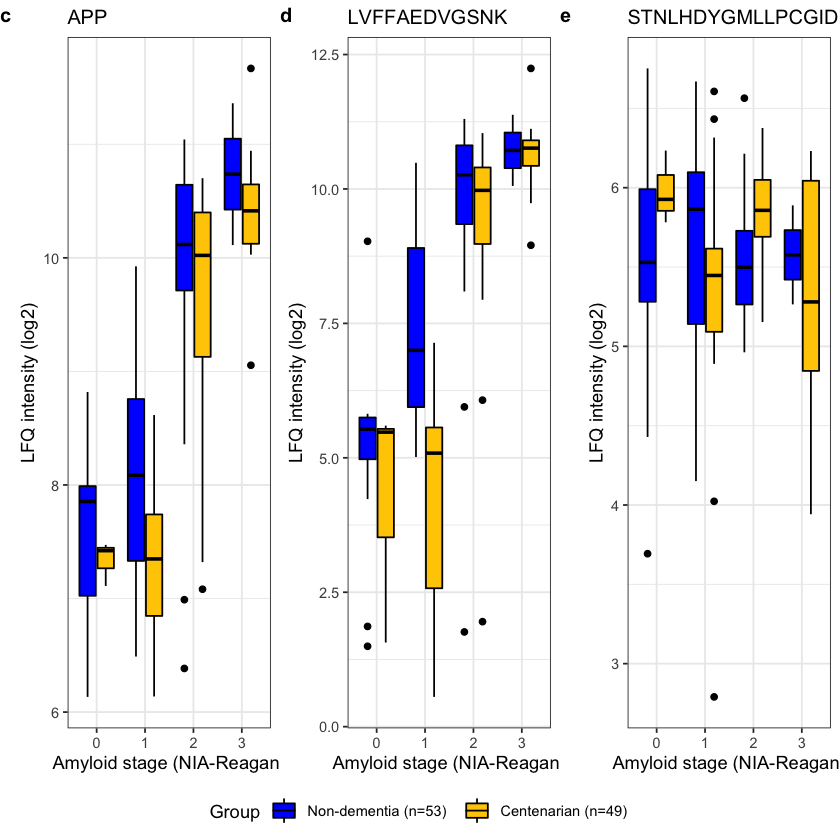

In [72]:
Amyloid_plot <- plot_grid(APP_peptide_plot, legend, align = "v", axis = "r", rel_heights = c(0.93, 0.07), nrow = 2)
Amyloid_plot

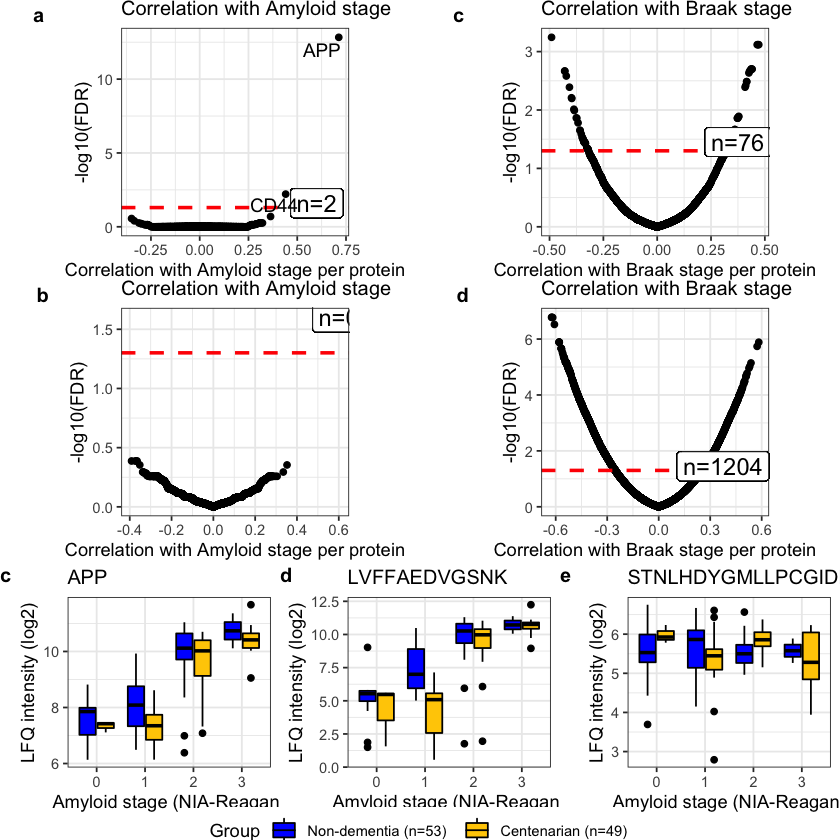

In [80]:
all_plot <- plot_grid(corr_plot, Amyloid_plot, align = "v", rel_heights = c(0.6, 0.3), 
                      nrow = 2)
all_plot

In [81]:
save_plot("100_plus_plots/proteomics/Protein_correlation_and_amyloid_peptides_updateAmyloid_and_Braak_include_plotinAD_20220905.pdf", 
          all_plot, base_height = 10, base_width = 10)